# Latency Arbitrage
## Two Market Model

TODO:
   7. add a second market
   8. add routing
   9. update SIP
   10. (At time time, a system w/o LA is complete)
   11. plot
   12. add LA
   13. add other measures

In [1]:
%matplotlib inline
import numpy as np
import bisect
import matplotlib.pyplot as plt
from collections import deque
import seaborn as sns

import warnings

warnings.simplefilter("error")

## Classes and functions

In [2]:
class order:
    def __init__(self, price, valuation, time):
        self.p = price
        self.pv = valuation
        self.t = time
    def __getitem__(self, i):
        if i is 0:
            return self.p
        if i is 1:
            return self.pv
        if i is 2:
            return self.t
        else:
            raise IndexError("{} is not a valid index.\n Use 0 for price, 1 for valuation, 2 for time".format(i))

In [3]:
class KeyWrapper:
    def __init__(self, iterable, key):
        self.it = iterable
        self.key = key

    def __getitem__(self, i):
        return self.key(self.it[i])

    def __len__(self):
        return len(self.it)

In [4]:
def surplus(ask,bid,t):
    # ask/bid order: [price,valuation,time placed]
    p = ask.p # assmue ask is the incumbent order
    if t is ask.t: # unless bid is...
        p = bid.p
    return  np.exp(-rho*(t-bid.t))*(bid.pv-p) + \
            np.exp(-rho*(t-ask.t))*(p-ask.pv)

In [5]:
def clearing(askQ,bidQ,t,surpluses,execution_times,n_executions):
    if (askQ[0].p <= bidQ[-1].p):
        # clear the 2 orders
        ask = askQ.popleft()
        bid = bidQ.pop()
        # Metrics related to order clearning
        #     calculate the surplus
        surpluses.append(surplus(ask,bid,t))
        #     calculate the execution time (for one of them it's just 0)
        execution_times.append(abs(ask.t-bid.t))
        #     increment # order executed by two
        n_executions[0] += 2
        #     free up the two traders
        #n_orders -=2
    

In [6]:
def routing(o,P,mainQ,altQ,NBBO,main_o):
    if P >= NBBO and NBBO < main_o:
        idx = bisect.bisect(KeyWrapper(altQ, key=lambda c: c.p), o.p)
        altQ.insert(idx, o)
    else:
        idx = bisect.bisect(KeyWrapper(mainQ, key=lambda c: c.p), o.p)
        mainQ.insert(idx, o)

## Parameters

In [7]:
nt = 15000 #15000
nbt = 250
nbt1 = 125
nbt2 = 125
a = 0.001
r_bar = 100000
k = 0.05
s2pv = 100000000
spv = 10000
s2s = 150000000
ss = s2s**0.5 #12247.4
R = 2000
rho = 0.0006
l = 0.075*2 # an ZI agent arrives per 13 to 14 time steps
delta = 0 # variable, ranging from 0 10 1000 

## Seed

In [8]:
#np.random.seed(12345)

## Simulation

In [9]:
surplus_arr = []
exe_time_arr = []
spread_arr = []
vola_arr = []
for i in range(0,11):
    
    delta = i*100
    np.random.seed(12345)
    
    surplus_a = []
    exe_time_a = []
    spread_a = []
    vola_a = []
    for j in range(0,200):
    
        ZI_agent_arrival = np.random.exponential(1/l,nt)
        u = np.random.normal(0,ss,nt)

        NBBO_ask = order(float('inf'),float('inf'),0)
        NBBO_bid = order(-float('inf'),-float('inf'),0)
        SIP_q = deque([])

        M1_ask_q = deque()
        M1_ask_q.append(order(float('inf'),float('inf'),0))
        M1_bid_q = deque()
        M1_bid_q.append(order(-float('inf'),-float('inf'),0))

        M2_ask_q = deque()
        M2_ask_q.append(order(float('inf'),float('inf'),0))
        M2_bid_q = deque()
        M2_bid_q.append(order(-float('inf'),-float('inf'),0))

        r = [r_bar]

        t_prev_arrival = 0
        n_arrival = 0
        n_orders = 0
        n_orders1 = 0
        n_orders2 = 0

        surpluses = []
        n_executions = [0]
        execution_times = []
        spreads = []
        mqps = []

        for t in range(1,nt):
            
            # update price
            r.append(max(0,k*r_bar+(1-k)*r[t-1]+u[t]))

            # see if agent arrives
            if (n_orders < nbt and t_prev_arrival+ZI_agent_arrival[n_arrival]<t):
                # update arrival event scheduling
                t_prev_arrival += ZI_agent_arrival[n_arrival]
                n_arrival += 1
                # generate evaluation and place order
                d = np.random.normal(r[t],spv)
                PV = max(0,d)
                
                agent_market = np.random.normal()

                if (agent_market > 0.5): # M1 agent
                    if (np.random.normal() > 0.5): # buy
                        P = np.random.uniform(PV-R,PV)
                        if (P >= 0):
                            o = order(P,PV,t)
                            # Route to the right market
                            routing(o,P,M1_bid_q,M2_bid_q,NBBO_ask.p,M1_ask_q[0].p)
                            n_orders += 1
                            n_orders1 += 1
                    else: # sell
                        P = np.random.uniform(PV,PV+R)
                        if (P >= 0):
                            o = order(P,PV,t)
                            # Route to the right market
                            routing(o,P,M1_ask_q,M2_ask_q,NBBO_bid.p,M1_bid_q[-1].p)
                            n_orders += 1
                            n_orders1 += 1

                else: # M2 agent
                    if (np.random.normal() > 0.5): # buy
                        P = np.random.uniform(PV-R,PV)
                        if (P >= 0):
                            o = order(P,PV,t)
                            # Route to the right market
                            routing(o,P,M2_bid_q,M1_bid_q,NBBO_ask.p,M2_ask_q[0].p)
                            n_orders += 1
                            n_orders2 += 1
                    else: # sell
                        P = np.random.uniform(PV,PV+R)
                        if (P >= 0):
                            o = order(P,PV,t)
                            # Route to the right market
                            routing(o,P,M2_ask_q,M1_ask_q,NBBO_bid.p,M2_bid_q[-1].p)
                            n_orders += 1
                            n_orders2 += 1

                            
                # clear market bid-ask price
                # Clear if ask < bid
                clearing(M1_ask_q,M1_bid_q,t,surpluses,execution_times,n_executions)
                clearing(M2_ask_q,M2_bid_q,t,surpluses,execution_times,n_executions)
                # This entry needs order status from all markets
                sip_entry = [t+delta,
                             min(M1_ask_q[0],M2_ask_q[0], key=lambda c: c.p),
                             max(M1_bid_q[-1],M2_bid_q[-1], key=lambda c: c.p)]
                idx = bisect.bisect(KeyWrapper(SIP_q, key=lambda c: c[0]), sip_entry[0])
                SIP_q.insert(idx, sip_entry)
                
            # update NBBO (if previously scheduled)
            if (SIP_q and SIP_q[0][0]<t):
                NBBO_ask = SIP_q[0][1]
                NBBO_bid = SIP_q[0][2]
                SIP_q.popleft()
            
            if t < 3000:
                # record spread
                spread = 0.5*abs(M1_ask_q[0].p-M1_bid_q[-1].p)
                if (spread < float('inf')):
                    spreads.append(spread)
                spread = 0.5*abs(M2_ask_q[0].p-M2_bid_q[-1].p)
                if (spread < float('inf')):
                    spreads.append(spread)
                    
                # record midquote price
                if t%1 is 0:
                    mqp = abs(0.5*(NBBO_ask.p+NBBO_bid.p))
                    if (mqp < float('inf')):
                        mqps.append(mqp)
                        
        surplus_a.append(sum(surpluses))
        exe_time_a.append(sum(execution_times)/n_executions[0])
        spread_a.append(np.median(spreads))
        vola_a.append(np.log(np.std(mqps)))
                    
    surplus_arr.append(np.mean(surplus_a))
    exe_time_arr.append(np.mean(exe_time_a))
    spread_arr.append(np.median(spread_a))
    vola_arr.append(vola_a[0])

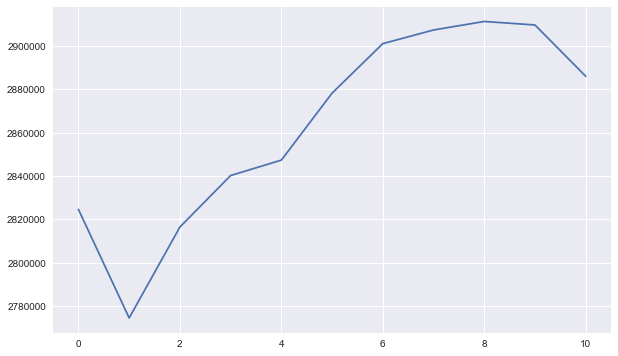

In [10]:
plt.figure(figsize=(10,6))
plt.plot(surplus_arr);

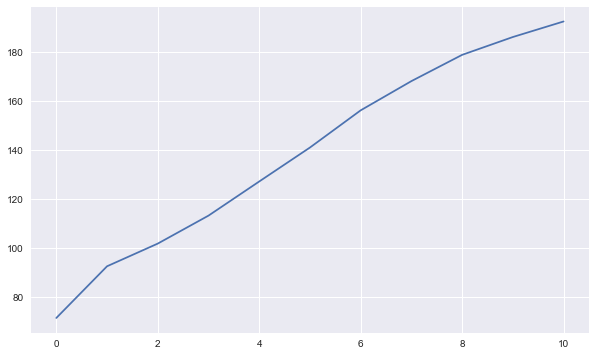

In [11]:
plt.figure(figsize=(10,6))
plt.plot(exe_time_arr);

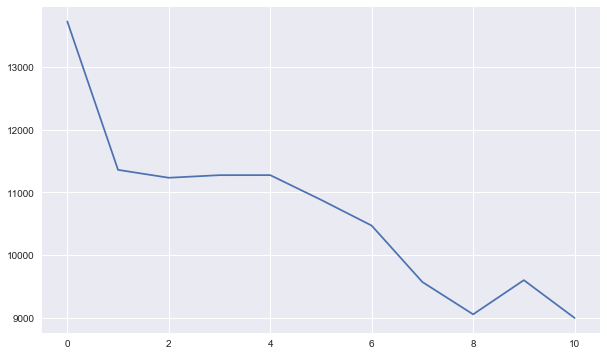

In [12]:
plt.figure(figsize=(10,6))
plt.plot(spread_arr);

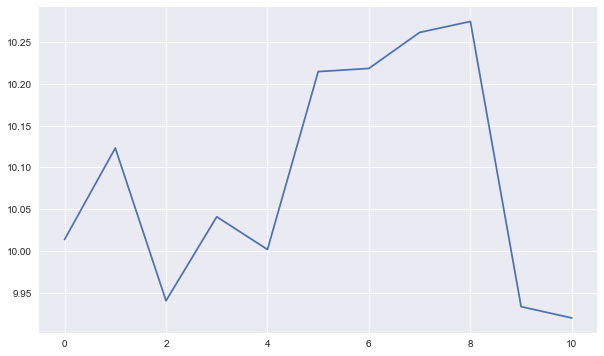

In [13]:
plt.figure(figsize=(10,6))
plt.plot(vola_arr);